Dataset Shape: (920, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None

Missing Values:
 id            0
age           0
sex           0
dataset       0
cp            0
t

/tmp/ipython-input-4080315682.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


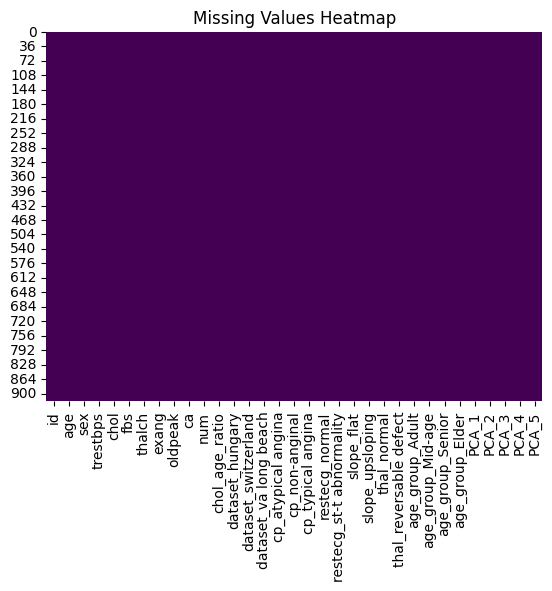

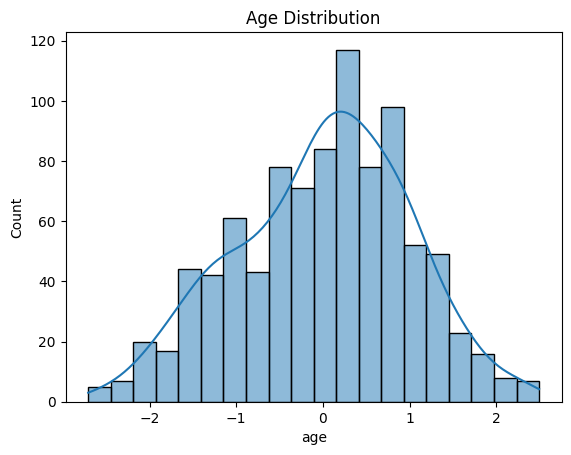

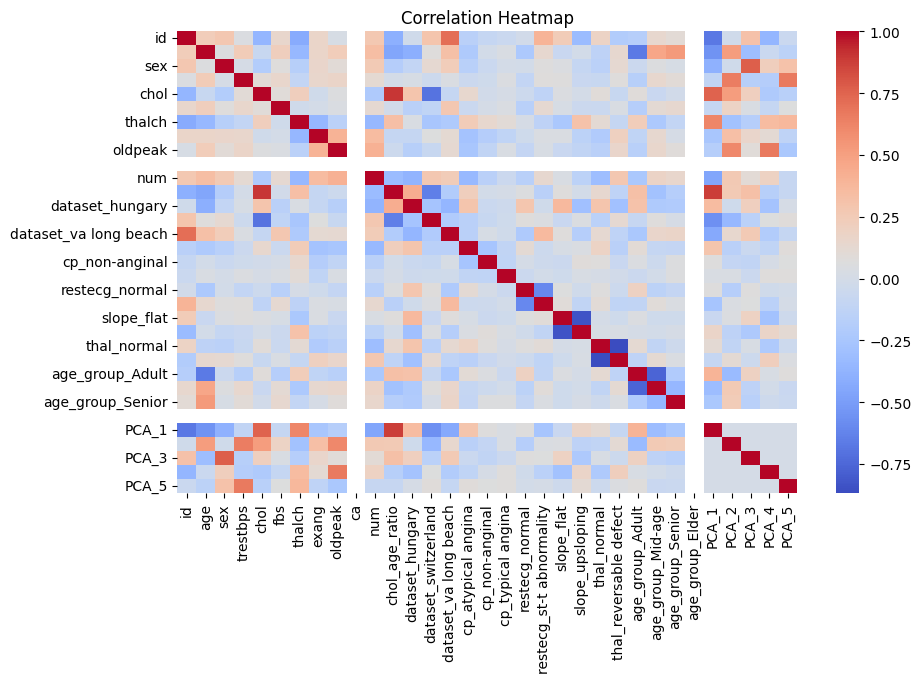

In [ ]:
# ==========================================
# 🧹 Data Cleaning & Feature Engineering
# Dataset: Heart Disease UCI
# Path: /content/drive/MyDrive/heart_disease_uci.csv
# ==========================================

# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# ==========================================
# 2. Load Dataset
# ==========================================
df = pd.read_csv('/content/drive/MyDrive/heart_disease_uci.csv')
print("Dataset Shape:", df.shape)
df.head()

# ==========================================
# 3. Data Cleaning
# ==========================================

# Check dataset info
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

# --- Handle Missing Values ---
# Fill numeric columns with median
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical columns with mode
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fix dtype issues (avoid FutureWarning)
df = df.infer_objects(copy=False)

# --- Remove Duplicates ---
df = df.drop_duplicates()

# --- Fix Inconsistent Formats (categorical to lowercase) ---
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.lower()

# --- Handle Outliers using IQR ---
for col in df.select_dtypes(include=np.number).columns:
    if col != "num":   # skip target column
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])

# ==========================================
# 4. Feature Engineering
# ==========================================

# Age Groups
if 'age' in df.columns:
    df['age_group'] = pd.cut(
        df['age'],
        bins=[20, 35, 50, 65, 80, 100],
        labels=['Young', 'Adult', 'Mid-age', 'Senior', 'Elder']
    )

# Cholesterol to Age Ratio
if 'chol' in df.columns and 'age' in df.columns:
    df['chol_age_ratio'] = df['chol'] / (df['age'] + 1)

# --- Encoding Categorical Variables ---
le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    if df[col].nunique() <= 2:   # Binary categories
        df[col] = le.fit_transform(df[col])

# One-Hot Encoding for multiclass features
df = pd.get_dummies(df, drop_first=True)

# --- Scaling Numerical Features ---
scaler = StandardScaler()
num_cols = df.select_dtypes(include=np.number).columns.drop("num")
df[num_cols] = scaler.fit_transform(df[num_cols])

# --- PCA (Optional Dimensionality Reduction) ---
pca = PCA(n_components=5, random_state=42)
pca_features = pca.fit_transform(df[num_cols])
pca_df = pd.DataFrame(pca_features, columns=[f'PCA_{i}' for i in range(1,6)])
df = pd.concat([df.reset_index(drop=True), pca_df], axis=1)

# ==========================================
# 5. Train/Test Split
# ==========================================
# Define Features & Target
X = df.drop('num', axis=1)
y = df['num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

# ==========================================
# 6. Save Final Cleaned Dataset
# ==========================================
df.to_csv('/content/drive/MyDrive/heart_disease_cleaned.csv', index=False)
print("✅ Cleaned dataset saved at: /content/drive/MyDrive/heart_disease_cleaned.csv")

# ==========================================
# 7. Visualization Examples
# ==========================================
# Missing values heatmap
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# Age distribution (after scaling may look centered)
if 'age' in df.columns:
    sns.histplot(df['age'], bins=20, kde=True)
    plt.title("Age Distribution")
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()
